<a href="https://colab.research.google.com/github/ninyx/dl_zero_shot/blob/main/ZeroShotObjectDetection_SAM_OpenCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Installing dependencies

In [ ]:
#Installing needed libraries
!pip install open_clip_torch --upgrade
!pip install open_clip_torch transformers
!pip install torch --upgrade
!pip install torchvision --upgrade

!pip install validators
!pip install opencv-python
!pip install matplotlib
!pip install -U nvidia-pytriton

!pip install opencv-python pycocotools matplotlib onnxruntime onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

# Downloading necessary files 

In [ ]:
#Downloading COCO 2017 validation test split
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip;
!unzip annotations_trainval2017.zip;


Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/00000019

# Importing libraries

In [ ]:
# Importing dependencies for YOLOv9 Pytriton and SAM Pytriton
import cv2
import torch
import torchvision
import open_clip

import numpy as np
import urllib.request
import validators
import matplotlib.pyplot as plt


from pytriton.client import ModelClient
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import json
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Zero-Shot Prediction with SAM and OpenCLIP

In [ ]:
class ZeroShot:
  def __init__(self):
    """
      Initializes the ZeroShot class.
    """
    # Load the OpenCLIP model and tokenizer
    self.open_clip_model, _, self.preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    self.tokenizer = open_clip.get_tokenizer('ViT-B-32')

    # Set the device to CUDA if available, otherwise use CPU
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.open_clip_model.to(self.device)

    # Set the paths for the COCO dataset annotations and images directory
    self.annotation_file = '/content/annotations/instances_val2017.json'
    self.coco_images_dir = '/content/val2017'

    # Load the COCO dataset
    self.coco = COCO(self.annotation_file)

  def _infer_yolov8(self, url="http://202.92.132.48:8000", image="../sam/images/dog_car.jpg", model="Yolov8x"):
    '''
    This function on the code provided by Rowel Atienza in their GitHub repository https://github.com/roatienza/mlops/blob/main/triton/yolo/client.ipynb. 
    The code snippet below shows the YOLOv8 inference used in their implementation:

    '''
    with ModelClient(url, model) as client:
      if validators.url(image):
          with urllib.request.urlopen(image) as url_response:
              img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
              image = cv2.imdecode(img_array, -1)
      else:
          image = cv2.imread(image)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      outputs = client.infer_sample(image)

      for k, v in outputs.items():
          if k == "names":
              names = v.tobytes().decode('utf-32').split("|")
              names = names[:-1]
          elif k == "bboxes":
              bboxes = v
          elif k == "probs":
              probs = v
  
    return names, bboxes, probs

  def _infer_SAM(self, url="http://202.92.132.48:8000", image="images/dog_car.jpg", model="SAM_h"):
    '''
    This function on the code provided by Rowel Atienza in their GitHub repository https://github.com/roatienza/mlops/blob/main/triton/sam/client.ipynb. 
    The code snippet below shows the SAM inference used in their implementation:

    '''
    with ModelClient(url, model) as client:
      if validators.url(image):
          with urllib.request.urlopen(image) as url_response:
              img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
              image = cv2.imdecode(img_array, -1)
      else:
          image = cv2.imread(image)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      outputs = client.infer_sample(image=image)
      segmentation = outputs['segmentation']
      #area = masks['area']
      masks = []
      for i in range(segmentation.shape[0]):
        if outputs['area'][i] > 400: #filter out masks with area below 400 square pixels
          masks.append({
              'segmentation': segmentation[i,:,:],
              'area': outputs['area'][i],
              "bbox": outputs['bbox'][i],
              # bounding boxes based on segmentation
              #"bboxes" : [min(segmentation[i,:,0]), min(segmentation[i,:,1]), max(segmentation[i,:,0]), max(segmentation[i,:,1])],
              "predicted_iou": outputs['predicted_iou'][i],
              "stability_score": outputs['stability_score'][i],
          })
      
    return image, masks
  
  def _show_anns(self, anns):
    '''
    Function displays segmentation masks generated from SAM
    '''
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

  def _crop_anns(self, image, anns):
    '''
    Generates list of cropped images based on the bounding boxes from the masks generated by SAM.
    These images will be run through OpenCLIP for Image Labeling

    Returns:
    - cropped_images: a list of numpy arrays that represent the cropped images from the original image.
    '''
    if len(anns) == 0:
        return []
    
    cropped_images = []
    
    for ann in anns:
      x, y, w, h = ann['bbox']
      
      # Crop the image region using the bounding box coordinates
      cropped_img = image[y:y+h, x:x+w]

      # Store the cropped image in a dictionary with the bounding box coordinates as the key
      cropped_images.append(Image.fromarray(cropped_img))
      
      # Display the cropped image

    return cropped_images

  def _iou(self, box1, box2):
    """
    Calculate the Intersection over Union (IoU) between two bounding boxes.
    
    Arguments:
    box1 -- numpy array of shape (4,) representing [x1, y1, x2, y2] of the first bounding box
    box2 -- numpy array of shape (4,) representing [x1, y1, x2, y2] of the second bounding box
    
    Returns:
    iou_score -- IoU score between the two bounding boxes
    """
    # Calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate the area of intersection
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # Calculate the area of the two bounding boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    # Calculate the IoU score
    iou_score = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou_score

  def text_descriptions(self):
    '''
    Generates prompt for OpenCLIP to identify cropped images from SAM

    Returns:
    - names: a list of the labels/categories based on COCO categories
    - text_descriptions: list of prompts to run on OpenCLIP
    '''
    names = [cat['name'] for cat in self.coco.loadCats(self.coco.getCatIds())] # image categories from COCO
    text_descriptions = [f"A cropped photo of a {name}" for name in names] # text prompt for OpenCLIP
    
    return names, text_descriptions
  
  def generate_label(self, cropped_images):
    """
    Generates labels and probabilities for a list of cropped images.

    Args:
    - cropped_images: A list of cropped images.

    Returns:
    - labels: A list of predicted labels for the cropped images.
    - probs: A list of corresponding prediction probabilities.
    """
    names, text_descriptions = self.text_descriptions()  # Retrieve names and text descriptions

    text_tokens = self.tokenizer(text_descriptions)  # Tokenize the text descriptions
    text_tokens = text_tokens.to(self.device)  # Move tokens to the appropriate device

    labels = []  # List to store predicted labels
    probs = []  # List to store prediction probabilities

    for idx, c_image in enumerate(cropped_images):
        image_input = self.preprocess(c_image).unsqueeze(0)  # Preprocess the cropped image
        image_input = image_input.to(self.device)  # Move the image to the appropriate device

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = self.open_clip_model.encode_image(image_input)  # Encode the image features
            text_features = self.open_clip_model.encode_text(text_tokens)  # Encode the text features
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize the image features
            text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize the text features
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)  # Calculate the probabilities

        top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)  # Get the top predicted labels and probabilities
        labels.append(names[top_labels.numpy()[0][0]])  # Append the predicted label to the list
        probs.append(top_probs.numpy()[0][0])  # Append the corresponding probability to the list

    return labels, probs

  def nms(self, masks, labels, probs, iouThresh):
    """
    Performs non-maximum suppression (NMS) on the bounding boxes based on their stability scores and probabilities.

    Args:
    - masks: A list of dictionaries containing the bounding box information.
    - labels: A list of predicted labels.
    - probs: A list of prediction probabilities.
    - iouThresh: The IoU (Intersection over Union) threshold for suppressing overlapping bounding boxes.

    Returns:
    - selected_bboxes: A list of selected bounding boxes after applying NMS.
    """
    bboxes = []  # List to store bounding box information

    # Filter bounding boxes based on stability score and probability
    for idx in range(len(masks)):
        x, y, w, h = masks[idx]['bbox']
        if masks[idx]["stability_score"] * probs[idx] > 0.5:
            bboxes.append([labels[idx], masks[idx]["stability_score"] * probs[idx], x, y, x + w, y + h])

    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)  # Sort bounding boxes by stability score in descending order

    selected_bboxes = []  # List to store selected bounding boxes

    while len(bboxes) > 0:
        max_box = bboxes.pop(0)  # Select bounding box with the highest stability score

        n_bbox = []
        for box in bboxes:
            if box[0] != max_box[0] or self._iou(np.array(max_box[2:]), np.array(box[2:])) < iouThresh:
                n_bbox.append(box)  # Append non-overlapping bounding boxes to a new list

        bboxes = n_bbox  # Update the list of bounding boxes
        selected_bboxes.append(max_box)  # Append the selected bounding box to the list

    return selected_bboxes

  def zero_shot_detect(self, image_path, showMask = True):
    """
    Performs zero-shot object detection on an image.

    Args:
    - image_path: The path to the input image.
    - showMask: A boolean flag indicating whether to display the image with masks.

    Returns:
    - nms_names: A list of detected object labels after applying non-maximum suppression.
    - nms_bboxes: A list of bounding boxes (coordinates) corresponding to the detected objects.
    - nms_probs: A list of probabilities associated with the detected objects.
    """

    image, masks = self._infer_SAM(image=image_path)
    cropped_images = self._crop_anns(image, masks)

    if showMask:
      plt.figure(figsize=(10,10))
      plt.imshow(image)
      self._show_anns(masks)
      plt.axis('off')
      plt.show() 

    labels, probs = self.generate_label(cropped_images) # label cropped images

    s_labels = []
    s_masks = []
    s_probs = []

    for mask, label, prob in zip(masks, labels, probs):
        if prob > 0.5:
            s_labels.append(label)
            s_masks.append(mask)
            s_probs.append(prob)

    nms_masks = self.nms(s_masks, s_labels, s_probs, iouThresh = 0.5) #perform nms to remove duplicate bounding boxes

    #names, bboxes, probs
    nms_names = []
    nms_bboxes = []
    nms_probs = []
    for mask in nms_masks:
      if mask[1] > 0.5:
        nms_names.append(mask[0])
        nms_probs.append(mask[1])
        nms_bboxes.append(mask[2:])
    
    return nms_names, nms_bboxes, nms_probs

  def zero_shot_visual(self, image_path = ""):
    """
    Detects objects in an image using different methods and displays the results.

    Args:
    - image_path: The path to the input image. If empty, a random image from the COCO dataset will be selected.

    Returns:
    None
    """
    to_plot = {}

    if image_path == "":
        # Get all image IDs
        imgIds = self.coco.getImgIds()

        # Select one image ID at random
        selected_id = imgIds[np.random.randint(len(imgIds))]

        # Load annotations for the selected image
        imgAnn = self.coco.getAnnIds([selected_id])
        coco_anns = self.coco.loadAnns(imgAnn)

        # Load the image
        img = self.coco.loadImgs(selected_id)[0]
        image_path = img['coco_url']

        gt_bboxes = []
        gt_names = []
        gt_probs = []
        for ann in coco_anns:
            x, y, w, h = ann['bbox']
            class_id = ann["category_id"]
            class_name = self.coco.loadCats(class_id)[0]["name"]

            gt_bboxes.append([x, y, x+w, y+h])
            gt_names.append(class_name)
            gt_probs.append(1)

        to_plot["COCO Ground Truth"] = [[name, box, prob] for name, box, prob in zip(gt_names, gt_bboxes, gt_probs)]

    image = image_path
    if validators.url(image):
        with urllib.request.urlopen(image) as url_response:
            img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
            image = cv2.imdecode(img_array, -1)
    else:
        image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    nms_names, nms_bboxes, nms_probs = self.zero_shot_detect(image_path)
    to_plot["SAM with OpenCLIP"] = [[name, box, prob] for name, box, prob in zip(nms_names, nms_bboxes, nms_probs)]

    yolo_names, yolo_bboxes, yolo_probs = self._infer_yolov8(image=image_path)
    to_plot["YOLOv8"] = [[name, box, prob] for name, box, prob in zip(yolo_names, yolo_bboxes, yolo_probs)]

    self.display(image, to_plot)

  def display(self, image, to_plot):
    '''
    Display Ground Truth from COCO Dataset, Zero-Shot Object Detection from SAM and OpenCLIP, Zero-Shot Object detection by YOLOv8

    Args:
    - image: The input image.
    - to_plot: dictionary of bounding boxes, labels, and confidence scores

    Returns:
    None

    '''
    fig, axes = plt.subplots(1, len(to_plot), figsize=(len(to_plot)*10, 10))

    # Iterate over the images and plot the bounding boxes
    for idx, plot in enumerate(to_plot):
      axes[idx].imshow(image)  
      axes[idx].set_title(plot)
      for label, bbox, prob in to_plot[plot]:
        if prob > 0.5:
          x1, y1, x2, y2 = bbox
          w = x2 - x1
          h = y2 - y1
          # make the color random
          color = np.random.rand(3,)
          rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
          axes[idx].add_patch(rect)
          # use the color and add transparency of 0.5
          color = np.append(color, 0.5)
          # add text with white background
          axes[idx].text(x1, y1, f"{label} {prob:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

        # Adjust the spacing between subp'''
      plt.tight_layout()
    
    # Show the plot
    plt.show()

  def COCO_prediction(self,dataset):
    """
    Generates COCO predictions for a subset of images.

    Returns:
    - resFile: The path to the JSON file containing the prediction results.
    - imgIds: A list of image IDs used for prediction.
    """
    imgIds = sorted(self.coco.getImgIds())
    imgIds = imgIds[:dataset]  # Select a subset of image IDs

    cocoPredAnns = []  # List to store COCO prediction annotations
    resFile = '/content/results.json'  # Path to the output JSON file

    for id in imgIds:
      imgAnn = self.coco.getAnnIds([id])
      coco_anns = self.coco.loadAnns(imgAnn)

      # Load the image
      img = self.coco.loadImgs(id)[0]
      image_path = img['coco_url']

      # Perform zero-shot object detection on the image
      nms_names, nms_bboxes, nms_probs = self.zero_shot_detect(image_path, showMask=False)

      for name, bbox, prob in zip(nms_names, nms_bboxes, nms_probs):
        x1, y1, x2, y2 = bbox
        cocoPredAnns.append({
            "image_id": int(id),
            "category_id": int(self.coco.getCatIds([name])[0]),
            "bbox": [int(x1), int(y1), int(x2 - x1), int(y2 - y1)],
            "score": float(prob)
        })

    # Save the prediction results to a JSON file
    with open(resFile, 'w') as f:
      json.dump(cocoPredAnns, f)

    return resFile, imgIds

  def COCO_mAP(self, dataset = 20):
    """
    Computes mAP (mean Average Precision) for a subset of images from the COCO dataset.

    Returns:
    - Display mAP statistics for selected subset
    """
    resFile, imgIds = self.COCO_prediction(dataset)  # Get the prediction results and image IDs

    cocoDt = self.coco.loadRes(resFile);  # Load the COCO detections

    print(f"mAP for {len(imgIds)} Images from COCO Dataset.")

    # Run COCO evaluation
    cocoEval = COCOeval(self.coco, cocoDt, 'bbox');
    cocoEval.params.imgIds = imgIds
    cocoEval.evaluate();
    cocoEval.accumulate();
    cocoEval.summarize()


# Main Program

**Zero-shot object detection** is the task of object detection where no visual training data is available for some of the target object classes.

The **Segment Anything Model (SAM)** is an object detection model that utilizes the concept of segmentation to detect and localize objects in images. SAM treats object detection as a semantic segmentation problem, where the goal is to assign a class label to each pixel in the image and then generate bounding boxes around the regions of interest. 

**OpenCLIP** is an open-source library that combines the power of OpenAI's CLIP (Contrastive Language-Image Pretraining) model with computer vision tasks. CLIP is a multimodal model trained on a large-scale dataset of images and their associated textual descriptions. It learns to understand the relationship between images and text, allowing it to perform tasks such as image classification, text-to-image retrieval, and zero-shot learning. 



## Initialize class for Zero Shot Object Detection



In [ ]:
detect = ZeroShot()

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


## Zero Shot Object Detection with SAM and OpenCLIP
### with YOLOv8 Comparison

Upload an image or paste an image url in the input prompt. 
If no input is detected, it will generate a random image from the COCO 2017 dataset.

This function will display the following:
- Segmentation masks generated from SAM
- Side-by-side plot of the Ground Truth, Zero Shot Object detections SAM with OpenCLIP, and ZeroShot Object Detection by YOLOv8


Input image path or url: 


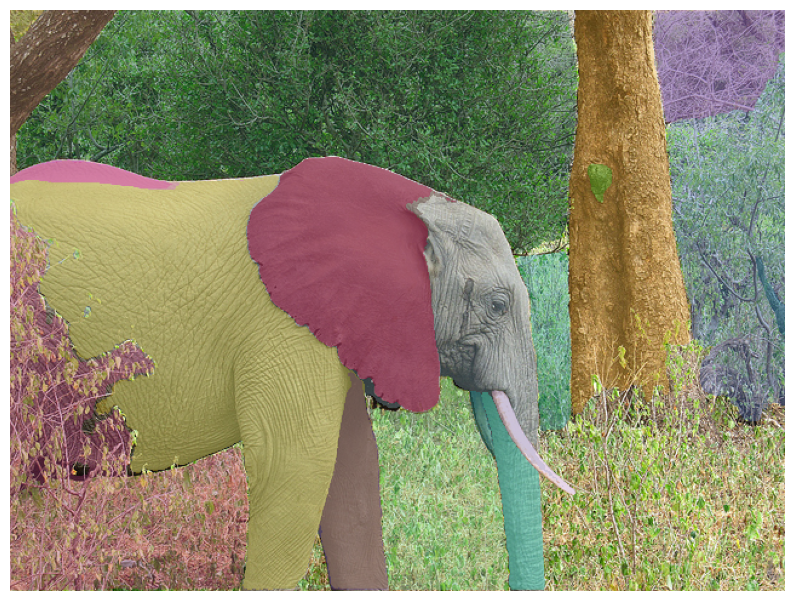

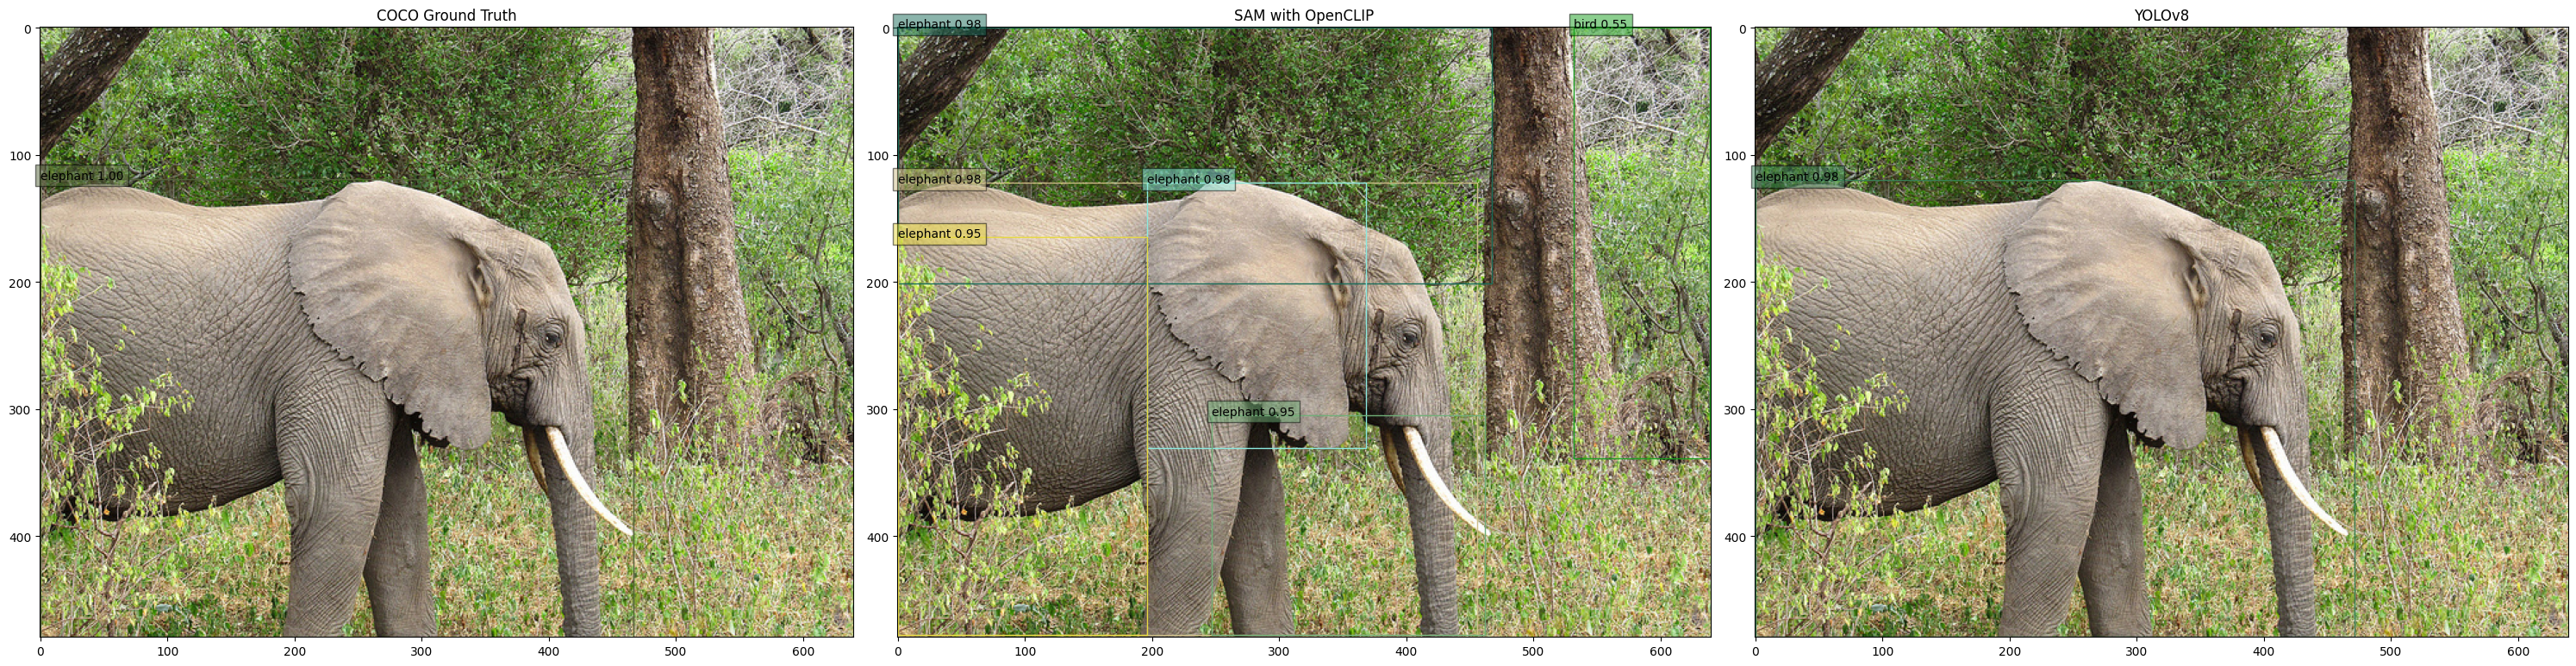

In [ ]:
image_path = input("Input image path or url: ")

detect.zero_shot_visual(image_path=image_path)

## Mean Average Precision with COCO 2017 Dataset

Displays the Mean Average Precision (mAP) of our zero shot object detection with SAM and OpenCLIP against the ground truth in COCO dataset. 

This mAP stats is for 30 images only. 

In [ ]:
dataset = 30 #@param {type:"integer"}

detect.COCO_mAP(dataset=dataset)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
mAP for 30 Images from COCO Dataset.
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.17s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.248
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU